In [1]:
#!/usr/bin/env python3
"""mock_continuous_signal.ipynb
James Gardner 2019
Melbourne Uni
"""

# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
# %matplotlib inline
from tqdm import tqdm_notebook as tqdm

In [2]:
class SineSignal(object):
    n_t = int(1e3)
    # ultimately, freq_prob will be half this size
    t = np.linspace(0,2*np.pi,n_t)    
    dt = t[1]-t[0]
    noise_scale = 5
    
    def __init__(self,raw_freq):
        self.raw_freq = raw_freq
        self.raw_signal = np.sin(raw_freq*2*np.pi*SineSignal.t)
        self.noise = np.random.normal(0,SineSignal.noise_scale,self.raw_signal.shape)
        self.injected_signal = self.raw_signal + self.noise
        self.yf = np.fft.fft(self.injected_signal)
        self.nrm_abs_yf = 2/SineSignal.n_t*np.abs(self.yf)
        self.inj_freq = np.fft.fftfreq(len(self.yf),SineSignal.dt)
        # np.fft.fftfreq outputs 0 to +inf then -inf to 0, so :N//2 gets +ve side; wild!
        self.freq_prob = self.nrm_abs_yf[:SineSignal.n_t//2]
        
    def plot(self):
        plt.figure(figsize=(14,7))
        plt.plot(SineSignal.t,self.injected_signal)
        plt.title("injected signal")
        plt.ylabel("signal value")
        plt.xlabel("signal time chunk")
        plt.show()
        plt.figure(figsize=(14,7))        
        plt.plot(self.inj_freq[:SineSignal.n_t//2],self.freq_prob)
        plt.title("discrete FFT")
        plt.ylabel("freq strength in signal")                
        plt.xlabel("frequency")
        plt.show()

In [3]:
# SineSignal(5).plot()

(500, 100)


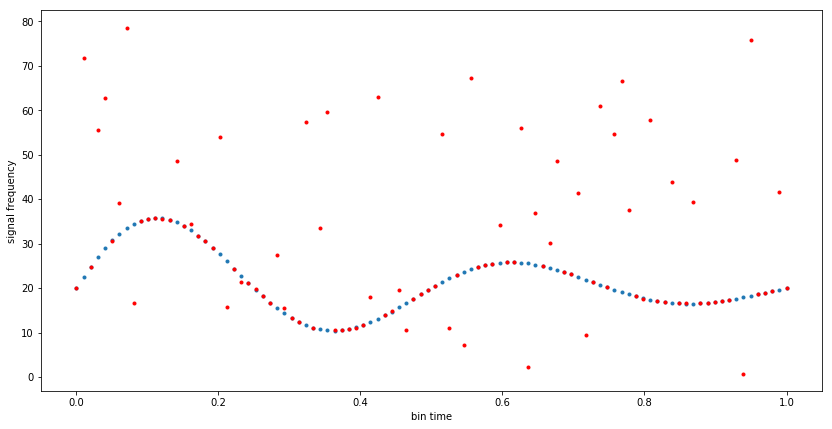

<Figure size 5040x2520 with 0 Axes>

In [4]:
long_timesteps = 100
bin_time = np.linspace(0,1,long_timesteps)
# again halve total number of points due to fft on real function
grid = np.zeros((SineSignal.n_t//2,long_timesteps))
print(grid.shape)

meander_amp = 20
meander_decay = 2
meander_freq = 2
meander = lambda x: meander_amp*np.exp(-x*meander_decay)*np.sin(meander_freq*2*np.pi*x)

wandering_freqs = meander(bin_time)+20

post_freq = []

for i,f in tqdm(enumerate(wandering_freqs)):
    thing_f = SineSignal(f)
    col = thing_f.freq_prob
    grid[:,i] = col
    post_freq.append(thing_f.inj_freq[col.argmax()])

plt.figure(figsize=(14,7))
plt.plot(bin_time,meander(bin_time)+20,'.')    
plt.plot(bin_time,post_freq,'r.')
plt.ylabel("signal frequency")
plt.xlabel("bin time")
plt.show()

plt.figure(figsize=(70,35))
plt.imshow(grid, cmap='viridis')
plt.gca().xaxis.tick_top()
plt.colorbar()
plt.ylabel('signal frequency bins')
plt.xlabel('long time bins')
plt.savefig('wandering.pdf')
plt.clf()

In [5]:
# n_t = int(1e3)
# # ultimately, freq_prob will be half this size
# t = np.linspace(0,2*np.pi,n_t)
# dt = t[1]-t[0]
# raw_freq = 20

# raw_signal = np.sin(raw_freq*2*np.pi*t)

# noise_scale = 0.2
# noise = np.random.normal(0,noise_scale,raw_signal.shape)

# injected_signal = raw_signal + noise
# # plt.plot(t,injected_signal)
# # plt.show()

# yf = np.fft.fft(injected_signal)
# nrm_abs_yf = 2/n_t*np.abs(yf)
# inj_freq = np.fft.fftfreq(len(yf),dt)
# # np.fft.fftfreq outputs 0 to +inf then -inf to 0, so :N//2 gets +ve side; wild!
# plt.plot(inj_freq[:n_t//2],nrm_abs_yf[:n_t//2])
# freq_prob = nrm_abs_yf[:n_t//2]

# plt.show()

In [6]:
# https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python
# N = 600
# # t = np.arange(N)/N*2*np.pi
# # t = np.arange(0,2*np.pi,T)
# t = np.linspace(0,2*np.pi,N)
# T = t[1]-t[0]

# y = np.sin(50*2*np.pi*t) + 0.5*np.sin(80*2*np.pi*t)
# # plt.plot(t,y)
# # plt.show()

# # nrm_abs_yf = 2/n_t*np.abs(yf)
# # inj_freq = np.fft.fftfreq(len(yf),dt)
# # plt.plot(inj_freq,nrm_abs_yf)

# yf = np.fft.fft(y)
# xf = np.linspace(0, 1/(2*T), N//2)
# plt.plot(xf, 2/N * np.abs(yf[:N//2]))
# plt.show()